In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [2]:
dataFEATURES = pd.read_csv('circuits_data425000.csv')
print(dataFEATURES.shape)

C:\Users\aadik\AppData\Local\Temp\ipykernel_29136\658666515.py:1: DtypeWarning: Columns (3,5,53) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFEATURES = pd.read_csv('circuits_data425000.csv')


(414820, 86)


In [3]:
DROP_COLS = [
    # ALMOST ALWAYS 1
    "connected_components",
    # WRONG FEATURES AND MANY MISSING VALUES
    "pagerank",
    "core_number",
    "sparsity",
    "memory_usage",
    "execution_time",
    "simulation_method",
    "automatic_transpiled_qubits",
    "transpiled_size",
    "transpiled_depth",
    "transpiled_qubits",
    "statevector_entropy",
    # REDUNDANT FEATURES CORRELATED WITH OTHERS
    "circuit_depth",
    "igdepth",
    "node_count",
    "circuit_qubits"
]

dataFEATURES = dataFEATURES.drop(columns=DROP_COLS)

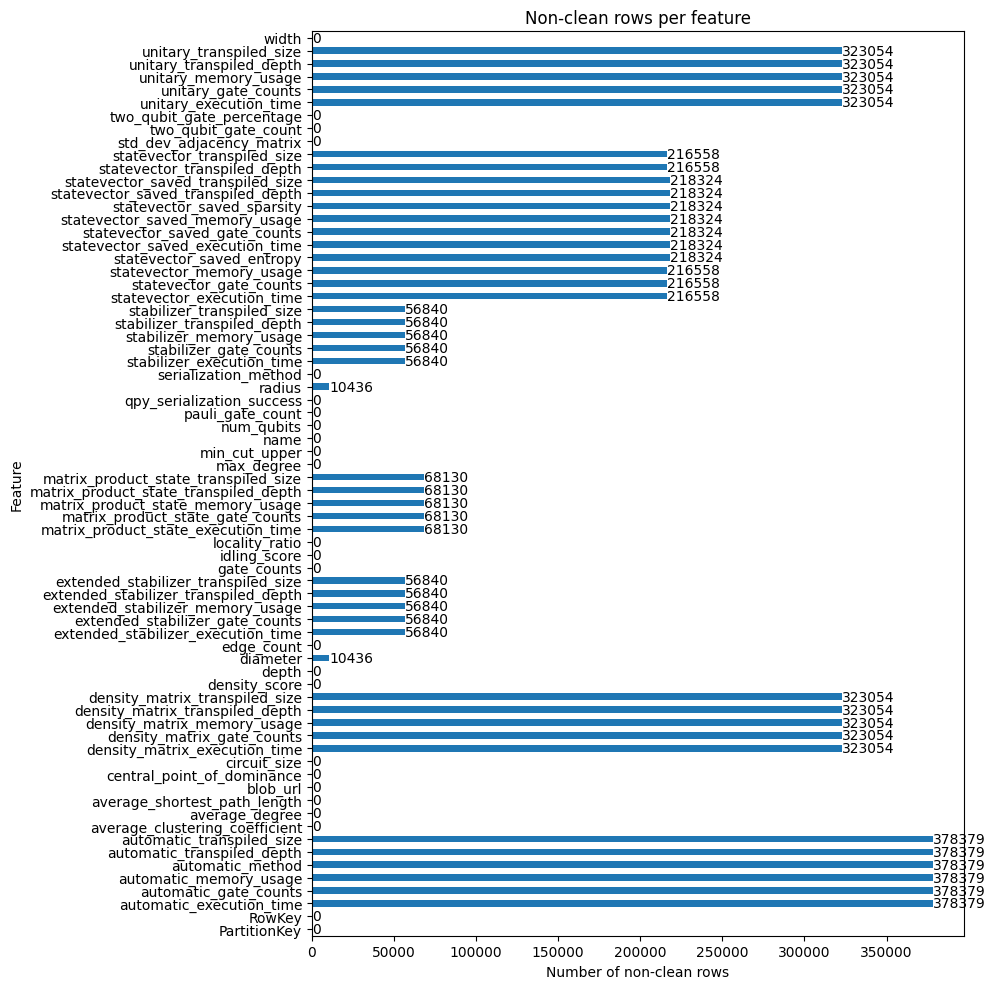

In [4]:
# dirty_counts = data.isna().sum()
dirty_counts = (
    dataFEATURES.replace(r"^\s*$", pd.NA, regex=True)
        .isna()
        .sum()
)

import matplotlib.pyplot as plt

ax = dirty_counts.plot(kind="barh", figsize=(10, 10))

for i, v in enumerate(dirty_counts):
    ax.text(v, i, str(v), va="center", ha="left")

plt.xlabel("Number of non-clean rows")
plt.ylabel("Feature")
plt.title("Non-clean rows per feature")
plt.tight_layout()
plt.show()



In [5]:
dataDYNAMIC = dataFEATURES.dropna(subset=["statevector_saved_entropy", "statevector_saved_sparsity"])
print(len(dataDYNAMIC), 4e5 - len(dataDYNAMIC))

196496 203504.0


In [6]:
dataGRAPH = dataFEATURES.dropna(subset=["radius", "diameter"])
print(len(dataGRAPH), 4e5 - len(dataGRAPH))

404384 -4384.0


In [7]:
dataCLEAN = dataDYNAMIC.dropna(subset=["radius", "diameter"])
print(len(dataCLEAN), 4e5 - len(dataCLEAN))

186407 213593.0


In [8]:
dataCLEAN_FEATURES = dataCLEAN.copy(deep=True)

METHODS = [
    "statevector_saved",
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic"
]

DROP_FAILED_SIM = [
    f"{m}_{suffix}"
    for m in METHODS
    for suffix in (
        "transpiled_size",
        "transpiled_depth",
        "memory_usage",
        "execution_time",
        "gate_counts",
    )
]

dataCLEAN_FEATURES = dataCLEAN_FEATURES.drop(columns=DROP_FAILED_SIM)
print(len(dataCLEAN_FEATURES))

186407


In [9]:
print("At least 1 sim worked")
dataSIM_ONE_WORKED = dataCLEAN.loc[
    dataCLEAN[DROP_FAILED_SIM].notna().any(axis=1)
].copy(deep=True)
print(len(dataSIM_ONE_WORKED))
dataSIM = dataCLEAN.dropna(subset=DROP_FAILED_SIM)
print("All sim worked: ")
print(len(dataSIM))
AUTO_COLS = [c for c in DROP_FAILED_SIM if c.startswith("automatic_")]
dataSIM_AUTOMATIC_WORKED = dataCLEAN.loc[
    dataCLEAN[AUTO_COLS].notna().any(axis=1)
].copy(deep=True)
print("Auto worked")
print(len(dataSIM_AUTOMATIC_WORKED))
# SANITY CHECK
AUTO_COLS = [c for c in DROP_FAILED_SIM if c.startswith("automatic_")]
OTHER_COLS = [c for c in DROP_FAILED_SIM if not c.startswith("automatic_")]

num_only_auto = (
    dataCLEAN[AUTO_COLS].notna().any(axis=1)
    & dataCLEAN[OTHER_COLS].notna().any(axis=1).eq(False)
).sum()

print("Only automatic worked:", num_only_auto)


At least 1 sim worked
186407
All sim worked: 
9896
Auto worked
27709
Only automatic worked: 0


In [10]:
dataCLEAN_FEATURES.to_csv("data_clean_features.csv", index=False)
dataSIM.to_csv("data_clean_sim.csv", index=False)
dataSIM_ONE_WORKED.to_csv("data_clean_sim_1_worked.csv", index=False)
dataSIM_AUTOMATIC_WORKED.to_csv("data_clean_sim_auto_worked.csv", index=False)